In [1]:
import onnxruntime as rt
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random

In [2]:
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

names = ['object']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

In [3]:
session = rt.InferenceSession(
    "../data/models/yolov7/yolov7-tiny.onnx", providers=rt.get_available_providers()
)

In [4]:
session.get_inputs()[0].name, session.get_outputs()[0].name

('images', 'output')

In [5]:
img = cv2.imread("../data/input/train_shelf_images/train1.jpg")
pilimage = Image.open("../data/input/train_shelf_images/train1.jpg")

In [6]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im /= 255
im.shape

(1, 3, 640, 640)

In [7]:
outname = [i.name for i in session.get_outputs()]
outname

inname = [i.name for i in session.get_inputs()]
inname

inp = {inname[0]:im}

In [8]:
outputs = session.run(outname, inp)[0]
outputs[0]

array([  0.        ,  44.407883  , 382.23026   , 106.23451   ,
       460.87308   ,   0.        ,   0.91727257], dtype=float32)

In [9]:
[img.copy()]

[array([[[166, 163, 184],
         [ 65,  58,  76],
         [132, 118, 133],
         ...,
         [215, 220, 197],
         [217, 220, 199],
         [220, 223, 202]],
 
        [[105,  97, 120],
         [ 67,  58,  77],
         [123, 107, 120],
         ...,
         [213, 218, 196],
         [214, 217, 196],
         [214, 217, 196]],
 
        [[107,  93, 116],
         [ 87,  73,  90],
         [177, 157, 168],
         ...,
         [209, 212, 191],
         [212, 217, 197],
         [214, 219, 199]],
 
        ...,
 
        [[200, 205, 199],
         [200, 206, 204],
         [194, 203, 208],
         ...,
         [123, 126, 135],
         [123, 123, 133],
         [124, 127, 136]],
 
        [[199, 205, 201],
         [194, 202, 204],
         [190, 200, 210],
         ...,
         [103, 103, 113],
         [103, 101, 114],
         [104, 104, 116]],
 
        [[194, 203, 198],
         [193, 203, 204],
         [182, 194, 208],
         ...,
         [103, 101, 112],
  

0:[44, 302, 106, 381]
1:[168, 204, 229, 286]
2:[104, 203, 166, 286]
3:[173, 301, 232, 380]
4:[233, 200, 292, 289]
5:[0, 80, 51, 179]
6:[52, 80, 120, 181]
7:[110, 299, 169, 380]
8:[535, 0, 599, 67]
9:[296, 199, 356, 289]
10:[426, 203, 487, 287]
11:[137, 1, 206, 60]
12:[186, 79, 252, 183]
13:[300, 302, 359, 381]
14:[61, 2, 137, 58]
15:[254, 89, 319, 182]
16:[120, 78, 185, 184]
17:[358, 204, 429, 286]
18:[172, 411, 234, 481]
19:[470, 0, 533, 64]
20:[-2, 301, 45, 383]
Unable to save detection 20, with boxes: [-2, 301, 45, 383]
OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:783: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'

21:[364, 399, 418, 480]
22:[36, 203, 101, 288]
23:[319, 89, 388, 181]
24:[520, 76, 576, 153]
25:[594, 83, 618, 132]
26:[107, 410, 167, 481]
27:[583, 149, 620, 206]
28:[421, 400, 479, 476]
29:[507, 201, 566, 274]
30:[621, 83, 640, 133]
31:[452, 79, 517, 184]
32:[479, 400, 533, 476]
33:[598, 4, 639, 67]
34

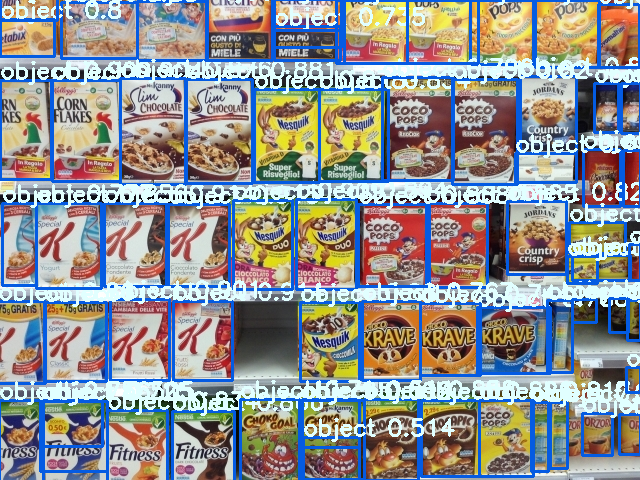

In [16]:
ori_images = [img.copy()]
# cropped_images = [


for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(outputs):
    
    image = ori_images[int(batch_id)]
    box = np.array([x0,y0,x1,y1])
    box -= np.array(dwdh*2)
    box /= ratio
    box = box.round().astype(np.int32).tolist()
    cls_id = int(cls_id)
    score = round(float(score),3)
    name = names[cls_id]
    color = colors[name]
    name += ' '+str(score)
    cv2.rectangle(image,box[:2],box[2:],color,2)
    cv2.putText(image,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)
    print(f"{i}:{box}")
    try:
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        save_path = f"../data/output/image_{int(i)}_{i}.jpg"
        cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR)[box[1]:box[3], box[0]:box[2]])
    except Exception as e:
        print(f"Unable to save detection {i}, with boxes: {box}")
        print(e)
Image.fromarray(ori_images[0])

In [11]:
# [274, -1, 341, 30]
image[-1:30, 273:341]

array([], shape=(0, 68, 3), dtype=uint8)

In [12]:
cv2.imshow("img",img[box[1]:box[3], box[0]:box[2]])
cv2.waitKey(0)

-1

In [13]:
image_bgr[box[1]:box[3], box[0]:box[2]]

array([[[226,  91,   4],
        [226,  91,   4],
        [226,  91,   4],
        ...,
        [226,  91,   4],
        [226,  91,   4],
        [226,  91,   4]],

       [[226,  91,   4],
        [226,  91,   4],
        [226,  91,   4],
        ...,
        [226,  91,   4],
        [226,  91,   4],
        [226,  91,   4]],

       [[226,  91,   4],
        [226,  91,   4],
        [ 40,  84, 107],
        ...,
        [ 50, 125, 151],
        [ 51, 126, 152],
        [226,  91,   4]],

       ...,

       [[226,  91,   4],
        [226,  91,   4],
        [255, 255, 225],
        ...,
        [255, 255, 225],
        [255, 255, 225],
        [226,  91,   4]],

       [[226,  91,   4],
        [226,  91,   4],
        [255, 255, 225],
        ...,
        [255, 255, 225],
        [ 62,  84, 149],
        [226,  91,   4]],

       [[226,  91,   4],
        [226,  91,   4],
        [226,  91,   4],
        ...,
        [226,  91,   4],
        [226,  91,   4],
        [226,  91,   4]]

In [22]:
type(img)

numpy.ndarray